In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.preprocessing import OneHotEncoder
import shap
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
#зададим графикам единый стиль
plt.rcParams.update({
    'axes.facecolor': 'ivory',    # графики получат бежевый фон
    'figure.facecolor': 'white'   # цвет фигуры будет слоновой кости
})
sns.set_theme(rc={'axes.facecolor': '#faf2ee',
                  'axes.edgecolor': '#745754',
                  'axes.grid': True,
                  'grid.linewidth': 0.4,
                  'font.family': ['serif'],
                  'axes.titlesize': 14,
                  'axes.labelsize': 12, 
                  'legend.facecolor': '#fffdfd',
                  'legend.edgecolor': '#745754',
                  'legend.fancybox': False
                 })
sns.set_palette(['#1d4f75', '#7AC5CD', '#B0E0E6', '#96CDCD',
                 '#BDB76B', 
                 '#CDBE70', '#8FBC8F', 
                 '#9BCD9B', '#2d9395', '#206869', '#008080',
                 '#4A708B', '#cc837d', '#afb4cb', '#cc836d',
                 '#afb4cb', '#2d9395', '#206869', '#b2b4bb',
                 '#1d4f74', '#8FBC8F', '#9BCD9B', '#cc836d', ])

Чтобы постоянно не запускать один и тот же код, введем две функции: для расчета основных характеристик построенной регрессии и для проведения стандартизации

In [3]:
def scaler(train_X, test_X):
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.fit_transform(test_X)
    return train_X, test_X

In [4]:
def regression(train_X, train_y, test_X, test_y):
    reg = LinearRegression().fit(train_X, train_y)
    predictions = reg.predict(test_X)
    print(f'MSE: {mean_squared_error(test_y, predictions)}')
    print('R2 Score на test:', r2_score(test_y, predictions))

<div class="alert alert-block alert-info">Для оценки моделей будут взяты такие метрики:
    
    1. R^2, так как метрика - довольно проста и независима от масштаба данных, однако у нее есть чувствительность к выбросам.
    
    2. MSE, чувствителен к большим отклонениям (выявляет выбросы) и удобен для оптимизации, но зависит от масштаба данных и штрафует сильнее за крупные ошибки.
    
    Так как мы в дальнейшем работаем с выбросами, это не составляет проблемы. Использование R² и MSE вместе позволяет оценить как общую адекватность модели (R²), так и точность прогнозов (MSE).

### Загрузка данных

In [123]:
df = pd.read_csv("CAR DETAILS FROM CAR DEKHO.csv")
df

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner
...,...,...,...,...,...,...,...,...
4335,Hyundai i20 Magna 1.4 CRDi (Diesel),2014,409999,80000,Diesel,Individual,Manual,Second Owner
4336,Hyundai i20 Magna 1.4 CRDi,2014,409999,80000,Diesel,Individual,Manual,Second Owner
4337,Maruti 800 AC BSIII,2009,110000,83000,Petrol,Individual,Manual,Second Owner
4338,Hyundai Creta 1.6 CRDi SX Option,2016,865000,90000,Diesel,Individual,Manual,First Owner


In [101]:
#общая информация по датасету, типы данных хорошие, пропусков нет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [102]:
df.describe()

,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


In [103]:
#есть 763 дубликата, удалим их
df.duplicated().sum()

763

In [124]:
df = df.drop_duplicates()
df

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner
...,...,...,...,...,...,...,...,...
4335,Hyundai i20 Magna 1.4 CRDi (Diesel),2014,409999,80000,Diesel,Individual,Manual,Second Owner
4336,Hyundai i20 Magna 1.4 CRDi,2014,409999,80000,Diesel,Individual,Manual,Second Owner
4337,Maruti 800 AC BSIII,2009,110000,83000,Petrol,Individual,Manual,Second Owner
4338,Hyundai Creta 1.6 CRDi SX Option,2016,865000,90000,Diesel,Individual,Manual,First Owner


Посмотрим значения в ячейках некоторых столбцов

In [10]:
df['fuel'].unique()

array(['Petrol', 'Diesel', 'CNG', 'LPG', 'Electric'], dtype=object)

In [11]:
df['seller_type'].unique()

array(['Individual', 'Dealer', 'Trustmark Dealer'], dtype=object)

In [12]:
df['transmission'].unique()

array(['Manual', 'Automatic'], dtype=object)

In [13]:
df['owner'].unique()

array(['First Owner', 'Second Owner', 'Fourth & Above Owner',
       'Third Owner', 'Test Drive Car'], dtype=object)

In [14]:
df['name'].unique()

array(['Maruti 800 AC', 'Maruti Wagon R LXI Minor',
       'Hyundai Verna 1.6 SX', ..., 'Mahindra Verito 1.5 D6 BSIII',
       'Toyota Innova 2.5 VX (Diesel) 8 Seater BS IV',
       'Hyundai i20 Magna 1.4 CRDi'], dtype=object)

In [15]:
df['name'].value_counts()

Maruti Swift Dzire VDI               54
Maruti Alto 800 LXI                  48
Maruti Alto LXi                      42
Maruti Alto LX                       30
Maruti Swift VDI BSIV                28
                                     ..
Toyota Innova 2.5 E 8 STR             1
Nissan Micra XL CVT                   1
Mahindra Scorpio VLX AT 2WD BSIII     1
Toyota Corolla AE                     1
Hyundai i20 Magna 1.4 CRDi            1
Name: name, Length: 1491, dtype: int64

In [125]:
#удалим столбец name, так как он в дальнейшем не будет использован
df = df.drop(['name'], axis=1)

Теперь еще поработаем с выбросами перед разделением на тестовую и обучающую выборки

In [126]:
#найдем значения выбросов в границах 25 и 75 перцентилей
def ejection(col):
    q75 = np.percentile(df[col], 75)
    q25 = np.percentile(df[col], 25)
    iqr = q75 - q25
    ejection_h = q75 + iqr * 1.5
    ejection_l = q25 - iqr * 1.5
    ejection_count = df[col][(df[col] > ejection_h) | (df[col] < ejection_l)].count()
    ejection_perc = ejection_count/df[col].count() * 100
    return(ejection_h, ejection_l, ejection_count, ejection_perc)

In [127]:
ejection('selling_price')

(1200000.0, -400000.0, 170, 4.752585965893206)

In [128]:
#процент небольшой, удалим их
df = df[(df['selling_price'] <= ejection('selling_price')[0])].reset_index(drop=True)

In [129]:
ejection('km_driven')

(166018.5, -36697.5, 120, 3.5221602582917524)

In [130]:
#процент небольшой, удалим их
df = df[(df['km_driven'] <= ejection('km_driven')[0])].reset_index(drop=True)
df.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [22]:
df_corr = df.copy()

In [23]:
enc = OneHotEncoder(sparse_output = False)
to_enc = df_corr[["fuel", "seller_type", "transmission"]]
to_enc1 = enc.fit_transform(to_enc)
new_col = enc.get_feature_names_out(["fuel","seller_type","transmission"])
df_corr[new_col] = to_enc1
df_corr.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual
0,2007,60000,70000,Petrol,Individual,Manual,First Owner,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,2007,135000,50000,Petrol,Individual,Manual,First Owner,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,2012,600000,100000,Diesel,Individual,Manual,First Owner,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2017,250000,46000,Petrol,Individual,Manual,First Owner,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,2014,450000,141000,Diesel,Individual,Manual,Second Owner,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


C:\Users\perea\AppData\Local\Temp\ipykernel_15148\4046303539.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_corr.corr()[["selling_price"]].sort_values("selling_price", ascending = False),vmin = -1, vmax = +1, annot = True, ax = ax)


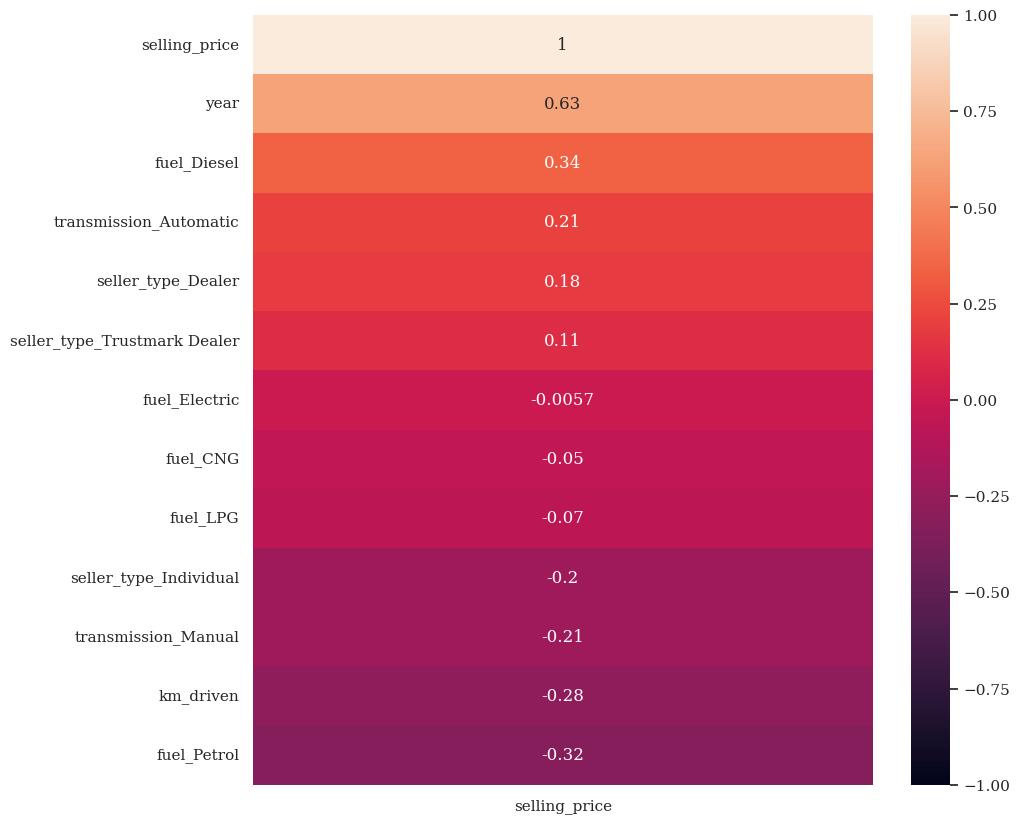

In [24]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_corr.corr()[["selling_price"]].sort_values("selling_price", ascending = False),vmin = -1, vmax = +1, annot = True, ax = ax)
plt.show()

Как видно, больше всего на зависимую переменную влияют переменные year, fuel_Diesel fuel_Petrol, однако мы их получили уже после кодировки, а во избежание утечки данных, мы не можем кодировать значения до разделения на тестовую и обучающую выборки. Соответственно, регрессию по этим параметрам до кодирования строить нельзя.

Разделим данные на train и test. В качестве зависимой переменной возьмем цену продажи.

In [139]:
X = df.drop(['selling_price'], axis=1)
y = df[['selling_price']]

In [140]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [141]:
train_X.columns

Index(['year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner'], dtype='object')

In [142]:
#разделим данные на категориальные и числовые
numerical = ['year', 'km_driven']
categorial = ['transmission', 'seller_type', 'fuel', 'owner']

In [143]:
#закодируем признаки с помощью One Hot Encoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(train_X[categorial])

#сначала данные train
features_name = encoder.get_feature_names_out(categorial)
train_X[features_name]= encoder.transform(train_X[categorial]).toarray()
train_X = train_X.drop(categorial, axis=1)

#потом данные test
test_X[features_name]= encoder.transform(test_X[categorial]).toarray()
test_X = test_X.drop(categorial, axis=1)

При данном варианте R2 Score на test: 0.5499156485013248. Теперь попробуем взять только вышеуказанные при корреляции столбцы в test и train 

In [30]:
test_X1 = test_X[['year', 'km_driven', 'fuel_Diesel', 'fuel_Petrol']]
test_X1

,year,km_driven,fuel_Diesel,fuel_Petrol
2211,2019,4000,1.0,0.0
670,2016,60000,0.0,1.0
2263,2018,25000,1.0,0.0
2420,2018,23000,0.0,1.0
999,2008,50000,0.0,1.0
...,...,...,...,...
979,2012,80000,1.0,0.0
2831,2014,50000,0.0,1.0
1506,2012,89000,1.0,0.0
911,2012,65000,1.0,0.0


In [31]:
train_X1 = train_X[['year', 'km_driven', 'fuel_Diesel', 'fuel_Petrol']]
train_X1

,year,km_driven,fuel_Diesel,fuel_Petrol
632,2011,100000,1.0,0.0
1941,2020,5000,0.0,1.0
445,2013,85036,1.0,0.0
617,2017,20000,0.0,1.0
2562,2013,73000,1.0,0.0
...,...,...,...,...
1095,2017,40000,1.0,0.0
1130,2017,35000,0.0,1.0
1294,2010,60000,0.0,1.0
860,2017,18591,0.0,1.0


In [32]:
regression(train_X1, train_y, test_X1, test_y)

MSE: 31616861577.985146
R2 Score на test: 0.5163013785051327


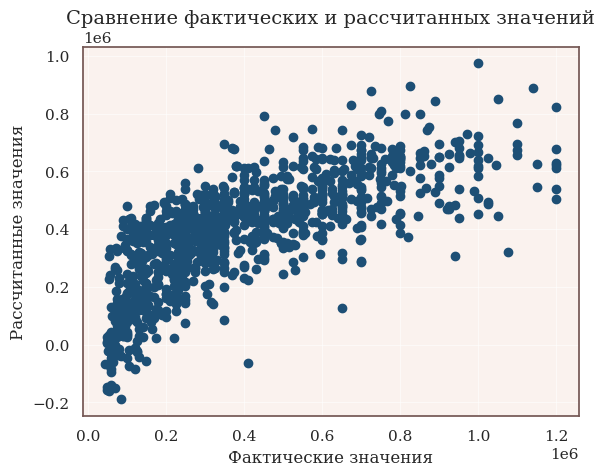

In [33]:
# Обучаем модель множественной регрессии
model = LinearRegression()
model.fit(train_X1, train_y)

# Делаем предсказания на тестовом наборе
y_pred = model.predict(test_X1)

# Создаем график с фактическими и рассчитанными значениями
plt.scatter(test_y, y_pred)
plt.xlabel('Фактические значения')
plt.ylabel('Рассчитанные значения')
plt.title('Сравнение фактических и рассчитанных значений')
plt.show()

При отборе столбцов R^2 получился ниже, а ошибка выше, что говорит о том, что отбор не дал хороших результатов

### Значение Шепли

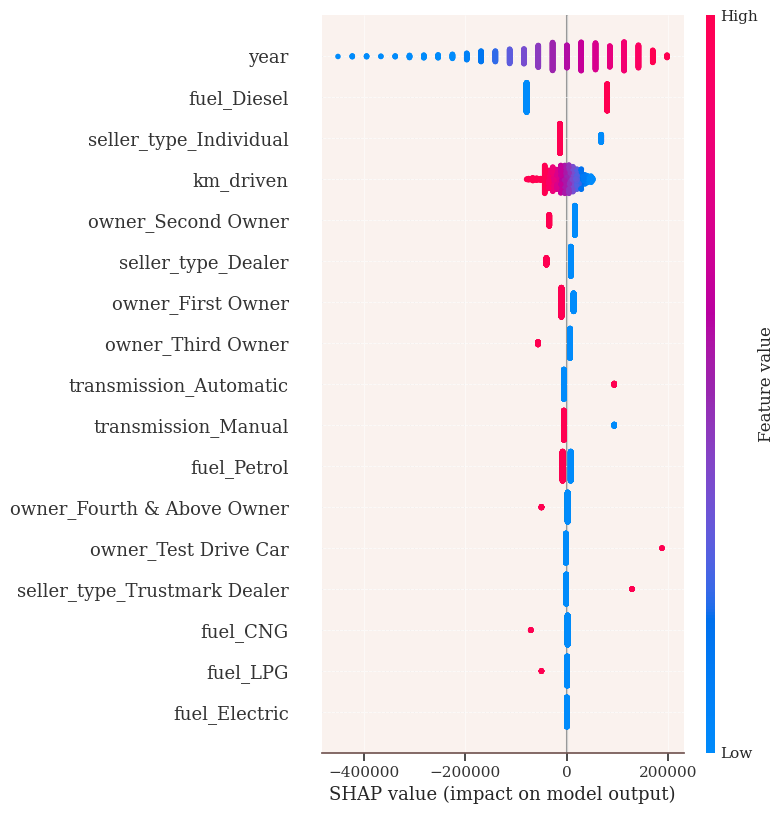

In [34]:
reg = LinearRegression().fit(train_X, train_y)
explainer = shap.Explainer(reg, train_X)
shap_values = explainer(test_X)
shap.summary_plot(shap_values, test_X)

In [35]:
perm = PermutationImportance(model.fit(train_X, train_y), random_state=42).fit(test_X, test_y)
eli5.show_weights(perm, feature_names=list(test_X.columns))

Weight,Feature
0.4816 ± 0.0261,year
0.1859 ± 0.0344,fuel_Diesel
0.0301 ± 0.0159,seller_type_Individual
0.0281 ± 0.0068,km_driven
0.0138 ± 0.0051,owner_Second Owner
0.0103 ± 0.0057,transmission_Manual
0.0100 ± 0.0080,transmission_Automatic
0.0077 ± 0.0064,seller_type_Dealer
0.0068 ± 0.0037,owner_Test Drive Car
0.0068 ± 0.0064,owner_Third Owner


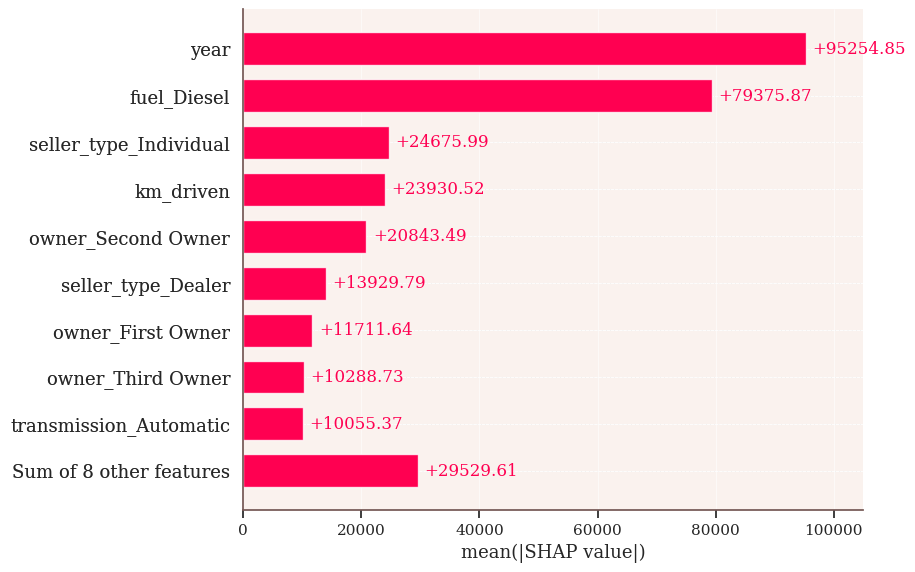

In [36]:
shap.plots.bar(shap_values)

Анализируя полученный выше результат, отберем переменные.

In [37]:
test_X = test_X[['year', 'fuel_Diesel', 'seller_type_Individual', 'km_driven', 'owner_Second Owner', 'transmission_Manual', 'transmission_Automatic']]
train_X = train_X[['year', 'fuel_Diesel', 'seller_type_Individual', 'km_driven', 'owner_Second Owner', 'transmission_Manual', 'transmission_Automatic']]

In [38]:
result = scaler(train_X, test_X)
regression(result[0], train_y, result[1], test_y)

MSE: 29762451608.284843
R2 Score на test: 0.5446715424386377


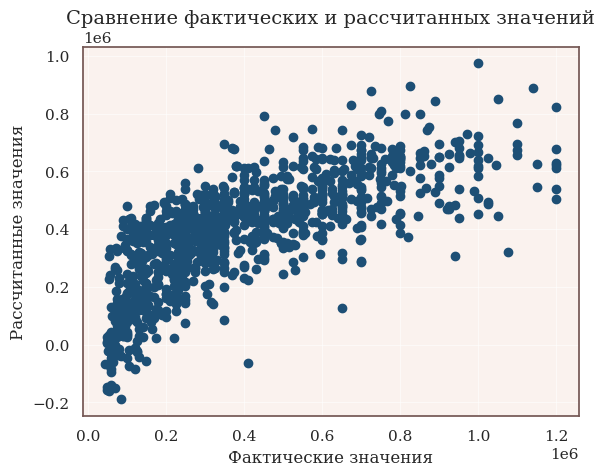

In [39]:
# Создаем график с фактическими и рассчитанными значениями
plt.scatter(test_y, y_pred)
plt.xlabel('Фактические значения')
plt.ylabel('Рассчитанные значения')
plt.title('Сравнение фактических и рассчитанных значений')
plt.show()

В данном случае результат получился почти как при применении обычной регрессии без отбора. Пока что он самый лучший.

### PCA

In [75]:
result = scaler(train_X, test_X)

In [76]:
pca = PCA(n_components=4, whiten=True)

In [77]:
pca = pca.fit(result[0])
train_X = pca.transform(result[0])
test_X = pca.transform(result[1])

In [78]:
regression(train_X, train_y, test_X, test_y)

MSE: 39556030799.21669
R2 Score на test: 0.39484197309728886


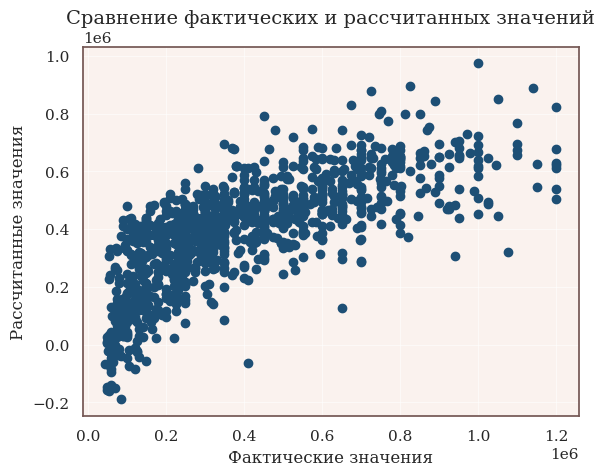

In [79]:
# Создаем график с фактическими и рассчитанными значениями
plt.scatter(test_y, y_pred)
plt.xlabel('Фактические значения')
plt.ylabel('Рассчитанные значения')
plt.title('Сравнение фактических и рассчитанных значений')
plt.show()

Видно, что результат снова полуичлся хуже по метрикам, чем при простой регрессии без отбора.

### Регрессия Lasso и Ridge

In [95]:
result = scaler(train_X, test_X)

R^2 по модели: 0.5491489632022541
MSE 29469785914.774776


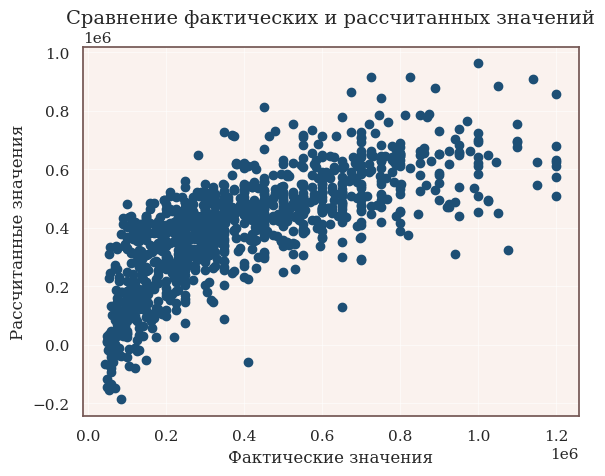

In [96]:
# создадим модель линейной регрессии
model = Ridge()

# обучим нашу модель
model.fit(result[0], train_y)

# делаем прогнозы
predictions = model.predict(result[1])

print('R^2 по модели:', r2_score(test_y, predictions))
print('MSE', mean_squared_error(test_y, predictions))

plt.scatter(test_y, predictions)
plt.xlabel('Фактические значения')
plt.ylabel('Рассчитанные значения')
plt.title('Сравнение фактических и рассчитанных значений')
plt.show()

In [136]:
result = scaler(train_X, test_X)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.315e+12, tolerance: 1.401e+10
  model = cd_fast.enet_coordinate_descent(


R^2 по модели: 0.5489637868296103
MSE 29481889930.54249


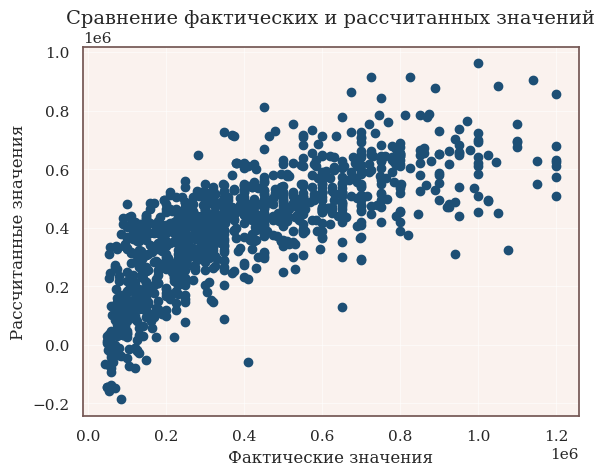

In [99]:
# создадим модель линейной регрессии
model = Lasso()

# обучим нашу модель
model.fit(result[0], train_y)


# делаем прогнозы
predictions = model.predict(result[1])

print('R^2 по модели:', r2_score(test_y, predictions))
print('MSE', mean_squared_error(test_y, predictions))

plt.scatter(test_y, predictions)
plt.xlabel('Фактические значения')
plt.ylabel('Рассчитанные значения')
plt.title('Сравнение фактических и рассчитанных значений')
plt.show()

### Дерево решений (регрессия)

In [116]:
model = DecisionTreeRegressor()
model.fit(train_X, train_y)
predictions = model.predict(test_X)
print(f"R2 на train: {model.score(train_X, train_y)}")
print(f"R2 на test: {model.score(test_X, test_y)}")

R2 на train: 0.8789612702897943
R2 на test: 0.3033830221756739


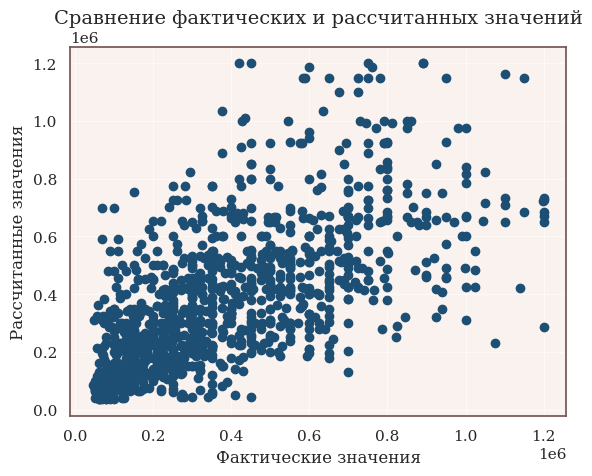

In [117]:
plt.scatter(test_y, predictions)
plt.xlabel('Фактические значения')
plt.ylabel('Рассчитанные значения')
plt.title('Сравнение фактических и рассчитанных значений')
plt.show()

Как видно, модель хорошо себя показывает на обучающей выборке, при этом на тестовой значение коэффициента детерминации довольно низкое.

### K-means

In [119]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [120]:
model = KNeighborsClassifier(n_neighbors=3)

# Обучение модели на обучающем наборе
model.fit(result[0], train_y)
predictions = model.predict(result[1])
print(f'MSE: {mean_squared_error(test_y, predictions)}')
print('R2 Score:', r2_score(test_y, predictions))

C:\ProgramData\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


MSE: 47505404590.76313
R2 Score: 0.27322645046756056


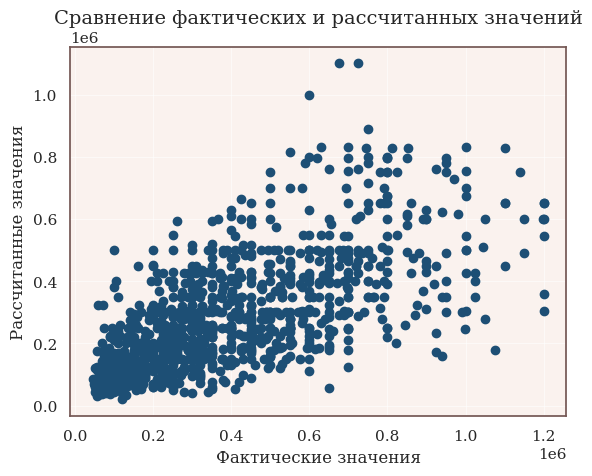

In [121]:
plt.scatter(test_y, predictions)
plt.xlabel('Фактические значения')
plt.ylabel('Рассчитанные значения')
plt.title('Сравнение фактических и рассчитанных значений')
plt.show()

### Дополнительные модели

In [137]:
# Создание и обучение модели RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(result[0], train_y)

# Прогнозирование на тестовом наборе
y_pred = model.predict(result[1])

# Оценка качества модели
mse = mean_squared_error(test_y, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2: {r2_score(test_y, y_pred)}')

C:\Users\perea\AppData\Local\Temp\ipykernel_15148\3063019666.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(result[0], train_y)


Mean Squared Error: 33483629178.776333
R^2: 0.48774215820027156


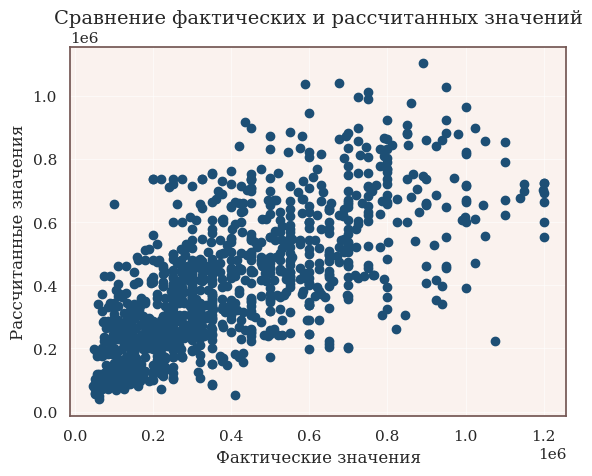

In [138]:
plt.scatter(test_y, y_pred)
plt.xlabel('Фактические значения')
plt.ylabel('Рассчитанные значения')
plt.title('Сравнение фактических и рассчитанных значений')
plt.show()

<div class="alert alert-block alert-info">Вывод:
    
    1. Наилучшая полученная по метрикам MSE и R^2 модель - обычная регрессия после разбиения на test, train закодированным стобцам без отбора признаков. Там R^2 был примерно развен 54.5499, а MSE - около 29 762 451 608. Второе место заняли модели регрессии Лассо и Риджа. У них немного ниже MSE (29 469 785 915 и 29 481 889 931), а R^2 практически такой же (0.5491 и 0.5489). Все остальные модели получились заметно хуже: с более высокой ошибкой и более низким коэффициентом детерминации. 
    
2. Самой же худшей моделью оказалась модель K-means. Там R^2 составил 0.2732, а MSE получился равным 47 505 404 591, то есть общая адекватность модели (R²) очень низкая, она плохо описывает данные; точность прогнозов (MSE) так же низкая, это подтверждается очень высоким значением MSE.

Проанализируем более подробно диаграмму рассеяния "Сравнение фактических и расчитанных значений" у наилучшей полученной модели.

<div class="alert alert-block alert-success">
    График показывает удовлетворительное соответствие между фактическими и рассчитанными значениями, однако сохраняется значительный разброс данных.
Большинство точек расположены близко к диагонали, что указывает на хорошее совпадение для средних значений.
Для низких и высоких значений (особенно выше 0.8 млн) наблюдается большая дисперсия : модель переоценивает или недооценивает результаты.

    Плюсы:
    1. Модель адекватно работает для среднего диапазона данных (0.3–0.7 млн).
    2. Разброс меньше, чем в случаях с другими моделями, что говорит о повышении точности.
    
    Минусы:
    1. Гетероскедастичность : ошибка увеличивается с ростом значений (шире разброс в правой части графика).
    2. Для крайних значений (менее 0.2 млн и более 1 млн) прогнозы не такие точные.

  Исходя из вышесказанного, модель демонстрирует хорошие результаты для средних значений, но требует улучшения для крайних случаев.